This notebook reads in Meg's black hole binary/quasar data and trains, runs, and evaluates a small transformer-based binary classifier on that data. It is meant to run locally and only uses one data file (10 1,000-time series data sets) - less accurate than the larger transformer in the script/other notebook.

In [1]:
from astropy.table import Table, Column
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

2024-04-19 15:58:58.118121: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import os

In [3]:
# #if you're not using google drive, ignore this cell
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
#change to your path for your downloaded dataset, whole notebook uses this

varying_binaries = '/home/3155/meg/data/Hackathon_2024_varyingbinaries_small.hdf5'

In [5]:
#looking at file structure
f = h5py.File(varying_binaries, 'r')

print(f.keys())

<KeysViewHDF5 ['data0', 'data1', 'data2', 'data3', 'data4', 'data5', 'data6', 'data7', 'data8', 'data9']>


In [6]:
def read_in_data(filepath, num_desired=11000):
  '''
  this function takes the path to a synthesized hdf5 data file
  and returns the data (format: dataframe) and corresponding labels (format: array)
  num_desired is a way to shorten the dataframe if you want to use less data
  '''
  f = h5py.File(filepath, 'r')
  for i, key in enumerate(f.keys()):
    #let's get the truth table from astropy table
    #there must be another way to do this but i don't know it and this is fast
    data = Table.read(filepath, format='hdf5', path=key) #read in the dataset in the file

    if i==0:
      truths = data.meta['truths']
      df_pd = pd.read_hdf(filepath, key).T #god i wish i could turn those error statements off
      df_pd = df_pd.drop(labels="time", axis=0)
    else:
      if len(df_pd) >= num_desired:
            df_pd = df_pd[:num_desired]
            truths = truths[:num_desired]
            return df_pd, truths
      truths_new = data.meta['truths']
      truths = np.concatenate((truths, truths_new))
      df_pd_new = pd.read_hdf(filepath, key).T #god i wish i could turn those error statements off
      df_pd_new = df_pd_new.drop(labels="time", axis=0)
      df_pd = pd.concat([df_pd, df_pd_new], ignore_index=True)

    
  return df_pd, truths



In [7]:
def read_in_data_folder(folderpath):
    '''
    this function takes the path to folder of synthesized hdf5 data files
    and returns one dataframe of all the time series and an array of corresponding labels
    '''
    for i, file in enumerate(os.listdir(folderpath)):
        data_filename = os.fsdecode(file)
        data_filename_full = folderpath + data_filename
        print(data_filename)
        if i==0:
            df_pd, truths = read_in_data(data_filename_full)
        else:
            df_pd_new, truths_new = read_in_data(data_filename_full)
            df_pd = pd.concat([df_pd, df_pd_new], ignore_index=True)
            truths = np.concatenate((truths, truths_new))
    return df_pd, truths
    

In [8]:
#you would use this for the whole folder, but instead we'll use the cell below
# df_pd, truths = read_in_data_folder("/home/3155/meg/data/")

In [9]:
df_pd, truths = read_in_data(varying_binaries, num_desired=2000) 
#num_desired is an easy way to subsample the data so that the transformer trains faster (and is worse)
#will throw errors that you can ignore

/lustre/lrspec/users/3155/anaconda3/envs/trans/lib/python3.11/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '0'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/lustre/lrspec/users/3155/anaconda3/envs/trans/lib/python3.11/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/lustre/lrspec/users/3155/anaconda3/envs/trans/lib/python3.11/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: '2'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural namin

In [10]:
df_pd.shape, truths.shape #checking shapes are as expected

((2000, 3650), (2000,))

In [11]:
df_pd.values[1002,:] #making sure that this isn't a time row

array([20.856924, 20.969366, 20.927279, ..., 20.594042, 20.617292,
       20.692049], dtype=float32)

In [12]:
#note that I transform the file so that each row is one time series
df_pd

,0,1,2,3,4,5,6,7,8,9,...,3640,3641,3642,3643,3644,3645,3646,3647,3648,3649
0,21.210102,21.350035,21.083570,21.175278,21.210041,21.170921,21.083193,21.183237,20.994253,20.920242,...,21.202715,21.271833,21.275412,21.298334,21.051867,21.285448,21.270426,21.321163,21.129803,21.292919
1,20.837322,20.726810,20.715109,20.848392,20.843235,20.810921,20.801249,20.630850,20.729607,20.732645,...,20.817419,20.667013,20.770535,20.731697,20.717646,20.775671,20.788340,20.896549,20.749918,20.908785
2,20.253635,20.210804,20.069777,20.281115,20.221827,20.080395,20.095810,20.196377,20.283316,20.226780,...,20.996691,20.884806,20.996353,20.978975,20.888960,21.109482,20.890514,20.768057,20.823999,20.838394
3,21.262705,21.053398,21.202196,21.279186,21.039227,21.353333,21.227972,21.057238,21.112095,21.081165,...,20.311132,20.248243,20.368124,20.432644,20.288378,20.225786,20.275335,20.152748,20.198233,20.273563
4,20.985954,20.982834,20.804131,20.863018,21.001146,20.941265,21.060610,20.902674,20.963903,20.830339,...,20.856112,21.025211,20.862272,20.851542,20.708948,20.963940,20.899782,20.756924,21.020205,21.099749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,20.837196,20.829832,20.799330,20.874622,21.079082,20.931530,20.862432,20.587530,20.863262,20.703312,...,21.086740,21.030722,21.049656,20.993832,20.799633,21.025867,20.889717,20.960304,20.954096,20.949120
1996,20.664902,20.694893,20.791582,20.806566,20.527180,20.769440,20.800049,20.855978,20.937859,20.881853,...,21.095543,21.009706,20.961075,20.799681,20.955952,21.156202,21.117834,21.079426,20.948296,20.879349
1997,20.948774,20.914145,20.986176,20.992306,20.836147,20.788012,20.792797,20.629330,21.063229,20.813942,...,21.257433,21.231237,21.171995,21.433002,21.209192,21.305517,21.163633,21.165535,21.367208,21.146767
1998,20.510403,20.394287,20.479923,20.454170,20.476503,20.545092,20.469193,20.560545,20.508884,20.608204,...,21.025106,20.904463,20.644838,20.841904,20.952780,20.768679,20.827129,20.820885,20.980602,20.922825


In [13]:
#i'm gonna do a few things to clean up the data...

#time is the axis label, so i'm removing it from the main dataframe
# df_pd = df_pd.drop(labels="time", axis=0)
#note - that step is now done in the read-in-data function 

#turning all of the missing values into nan's and then removing those times
df_pd = df_pd[df_pd>-900]
df_cut = df_pd.dropna(axis=1)
#NOTE - will need a more sophisticated method for this if the gaps in
#other datasets are not all at the same time

#also going to minmax normalize because the transformer will learn faster on that
def minmax_normalize(df):
    normalized_df = df.apply(lambda row: (row - row.min()) / (row.max() - row.min()), axis=1)
    return normalized_df

normalized_df = minmax_normalize(df_cut)

Text(0.5, 1.0, 'Dataframe visualization')

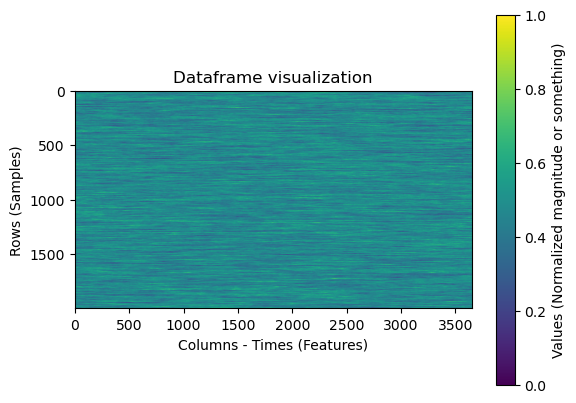

In [34]:
#let's look at the data again
plt.imshow(normalized_df.values, 
           cmap='viridis', 
           aspect=(len(normalized_df.values[0])/len(normalized_df.values[1])), 
                   interpolation=None)
plt.colorbar(label='Values (Normalized magnitude or something)')
plt.xlabel('Columns - Times (Features)')
plt.ylabel('Rows (Samples)')
plt.title('Dataframe visualization')

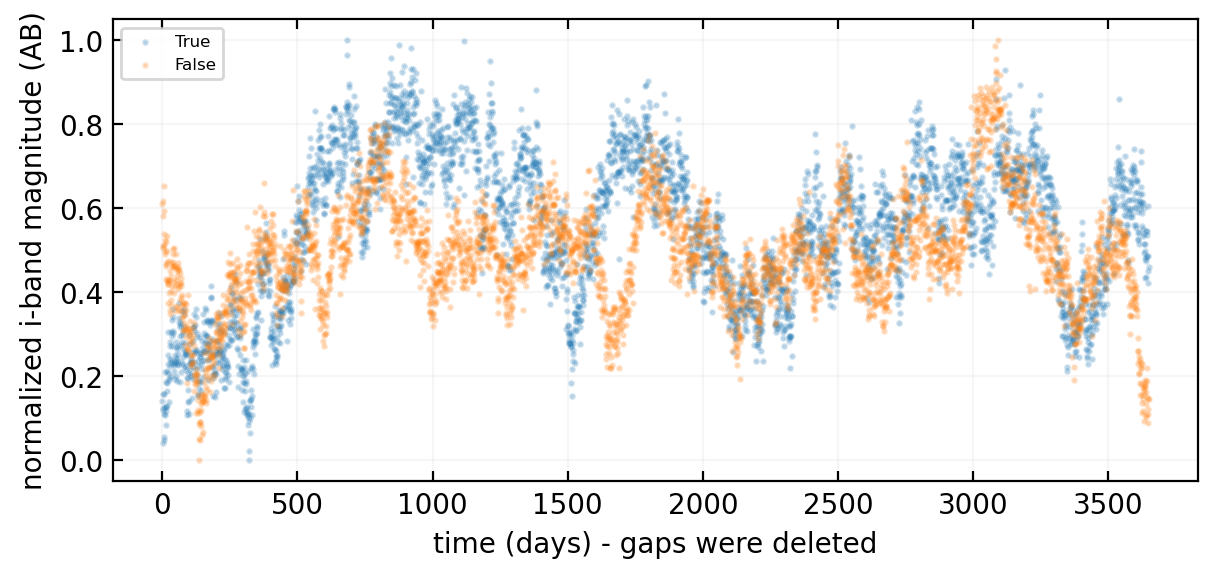

In [15]:
#and let's look at a few time series examples just for visualization's sake

#adapted from meg's code
#let's plot examples on one plot and put the binary truth in the label
fontsize = 10

fig, ax = plt.subplots(1, 1, figsize=(7, 3), dpi=200)

for i in range(2,4): #np.arange(0,len(normalized_df.values[i]))
    ax.scatter(list(normalized_df.columns.values), normalized_df.values[i], s=2 ,\
               alpha=0.2, label = truths[i])

    #plot mods
    ax.grid(True, alpha=0.1, zorder=10)
    plt.legend(fontsize=fontsize-4, loc='upper left')
    # ax.set_ylim(19.5, 22.2)
    plt.gca().invert_yaxis() #don't forget, we're working with magnitudes!

    #labels, titles, ticks
    ax.set_xlabel("time (days) - gaps were deleted", fontsize=fontsize)
    ax.set_ylabel("normalized i-band magnitude (AB)", fontsize =fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize,
                   top=True, right=False, bottom=True, left=True, direction='in')
    ax.tick_params(axis='both', which='minor', labelsize=fontsize,
                   top=True, right=False, bottom=True, left=True, direction='in')

In [16]:
#now splitting up the data into a training and testing set

data_train, data_test, label_train, label_test  = train_test_split(
     normalized_df, truths, test_size=0.3, random_state=4)

In [17]:
#keras likes for there to be an extra dimension in the data

def add_dim(X, swap=False):
    vals = X.values
    print(type(vals))
    reshaped = vals.reshape(vals.shape[0], vals.shape[1], 1)
    if swap:
        reshaped = np.swapaxes(reshaped, 1, 2)
    return reshaped

Xtrn = add_dim(data_train, swap=True)
Xtst = add_dim(data_test, swap=True)

Xtrn.shape, label_train.shape

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


((1400, 1, 3650), (1400,))

In [18]:
input_shape = Xtrn.shape[1:]
num_wvls = Xtrn.shape[2]
#num_wvls is the number of data points in each time series

In [19]:
#transformer architecture

def build_model(input_shape, num_wvls, num_classes, num_transformer_blocks):
    '''
    num_wvls is the number of data points in each time series
    '''
    inputs = layers.Input(shape=input_shape)
    x = inputs
    # Create multiple transformer blocks
    for _ in range(num_transformer_blocks):
        x0 = layers.MultiHeadAttention(num_heads=16, key_dim=64)(x, x)
        x0 = layers.Add()([x, x0])
        x0 = layers.LayerNormalization()(x0)
        x1 = layers.Conv1D(filters=2048, kernel_size=1, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01))(x0)
        x1 = layers.Conv1D(filters=num_wvls, kernel_size=1, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01))(x1)
        x1 = layers.Add()([x0, x1])
        x1 = layers.LayerNormalization()(x1)
        x = x1  # Update x for the next iteration
        
    #his is the end of the transformer part, now we work on the classification part
    #the transformer learns info about the time series and the a normal densely
    #connected NN does the classification
    x = layers.GlobalMaxPooling1D(data_format="channels_last")(x) 
    x = layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01))(x)
    # x = layers.Dense(96, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01))(x)
    x = layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01))(x)
    # x = layers.Dense(32, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01))(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    return model

In [20]:
#building the model
model = build_model(input_shape, num_wvls, num_classes=2, num_transformer_blocks=2) 
#num_transformer_blocks should be increased for better classification, but takes longer
model.summary()

2024-04-19 15:59:09.045014: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 3650)]    0           []                               
                                                                                                  
 multi_head_attention (MultiHea  (None, 1, 3650)     14957122    ['input_1[0][0]',                
 dAttention)                                                      'input_1[0][0]']                
                                                                                                  
 add (Add)                      (None, 1, 3650)      0           ['input_1[0][0]',                
                                                                  'multi_head_attention[0][0]']   
                                                                                              

In [21]:
#have not messed around with changing these
loss = losses.BinaryCrossentropy()
acc = metrics.BinaryAccuracy(name="ba")
opt = optimizers.Nadam(learning_rate=1e-5)
model.compile(loss=loss, optimizer=opt, metrics=[acc])

In [22]:
#early stopping callback
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=.01, patience=5, restore_best_weights=True)
# This callback will stop the training when there is no improvement in
# the loss for four consecutive epochs.
#also will restore the best weights instead of the most recent

In [23]:
#this took about five minutes for me

history = model.fit(
    Xtrn,
    label_train,
    # validation_data=(Xtst, label_test),
    batch_size=15,
    callbacks=earlystopping, #this is unnecessary for the baby neural network but i'm leaving it in - doesn't hurt
    epochs=10, #this should be longer but it takes more time
    validation_split=0.1,
    verbose=1
)

Epoch 1/10
84/84 [==============================] - 43s 455ms/step - loss: 107.6630 - ba: 0.5421 - val_loss: 106.0999 - val_ba: 0.6000
Epoch 2/10
84/84 [==============================] - 36s 429ms/step - loss: 104.3402 - ba: 0.7635 - val_loss: 102.8437 - val_ba: 0.5643
Epoch 3/10
84/84 [==============================] - 37s 440ms/step - loss: 100.9348 - ba: 0.8714 - val_loss: 99.5622 - val_ba: 0.6000
Epoch 4/10
84/84 [==============================] - 37s 440ms/step - loss: 97.5282 - ba: 0.9516 - val_loss: 96.3248 - val_ba: 0.5786
Epoch 5/10
84/84 [==============================] - 35s 413ms/step - loss: 94.1124 - ba: 0.9786 - val_loss: 92.8849 - val_ba: 0.5857
Epoch 6/10
84/84 [==============================] - 36s 424ms/step - loss: 90.6785 - ba: 0.9952 - val_loss: 89.4985 - val_ba: 0.6000
Epoch 7/10
84/84 [==============================] - 36s 428ms/step - loss: 87.2373 - ba: 0.9992 - val_loss: 86.0689 - val_ba: 0.5857
Epoch 8/10
84/84 [==============================] - 35s 424ms/st

In [24]:
#uncomment these/adjust paths if you want to save the trained neural network and its history
# model.save("NN_apr19") #name that it will save under
# np.save("/home/3155/meg/history_apr19/loss_history", history.history["loss"])
# np.save("/home/3155/meg/history_apr19/val_loss_history", history.history["val_loss"])
# np.save("/home/3155/meg/history_apr19/accuracy_history", history.history["accuracy"])
# np.save("/home/3155/meg/history_apr19/val_accuracy_history", history.history["val_accuracy"])

In [25]:
# -- print the accuracies for training and testing data
loss_tr, acc_tr = model.evaluate(Xtrn, label_train)
loss_te, acc_te = model.evaluate(Xtst, label_test)

print("Training accuracy : {0:.4f}".format(acc_tr))
print("Testing accuracy  : {0:.4f}".format(acc_te))

19/19 [==============================] - 2s 115ms/step - loss: 75.9201 - ba: 0.5883
Training accuracy : 0.9557
Testing accuracy  : 0.5883


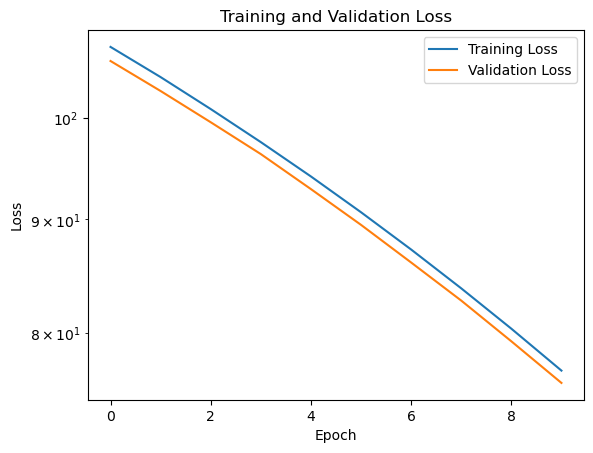

In [26]:
#plot loss function during training
plt.plot(history.history['loss'], label='Training Loss')
# Plot validation loss
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

#what we are hoping for is that the training continues for long enough that both losses flatten
#...in log space

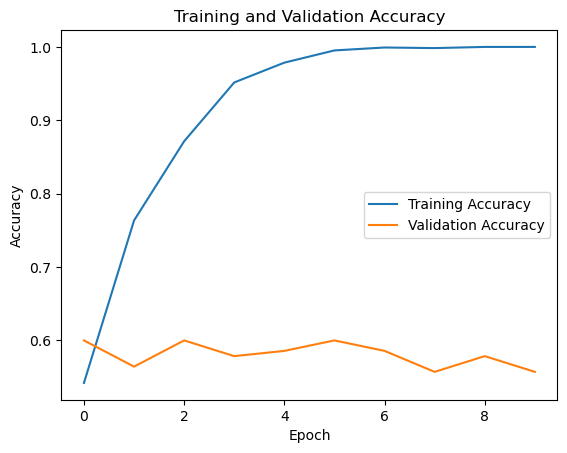

In [27]:
#plot accuracy  during training
plt.plot(history.history['ba'], label='Training Accuracy')
# Plot validation
plt.plot(history.history['val_ba'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

#if the accuracy is bad but the loss is low, 
#that means that the model is increasingly confident about its answers but not actually correct. 
#i have not run into that before this project, rip

Note: the output of this transformer is a sigmoid activation function, which means that it is a float between zero and one that is the probability that the transformer thinks it is true. Therefore, we can choose to a threshold above which we say that the prediction is "True." The threshold will control how many false negatives vs false positives we have.

In [28]:
#predictions on validation data (data that we didn't train on)
predictions = model.predict(Xtst)

19/19 [==============================] - 3s 140ms/step


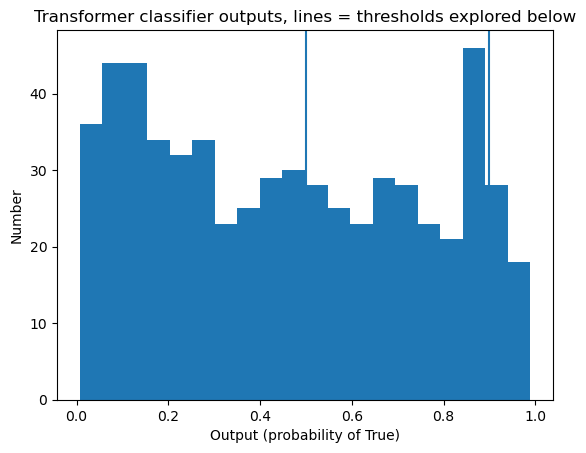

In [29]:
plt.hist(predictions, bins=20)
plt.title("Transformer classifier outputs, lines = thresholds explored below")
plt.ylabel("Number")
plt.xlabel("Output (probability of True)")
plt.axvline(.5)
plt.axvline(.9)

#this is to get a sense of the distribution of predictions

I will look at the confusion matrices for two thresholds - 50% and 90%

In [30]:
def plot_cm(preds, labels, threshold):
  binary_predictions = preds > threshold
  cm = confusion_matrix(label_test, binary_predictions)
  # Plot confusion matrix
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['False', 'True'], yticklabels=['False', 'True'])
  plt.xlabel('Predicted label')
  plt.ylabel('Actual label')
  plt.title('Transformer confusion matrix, threshold: '+str(threshold))
  plt.show()
  print("Upper left: true negatives")
  print("Upper right: false positives")
  print("Lower left: false negatives")
  print("Lower right: true positives")

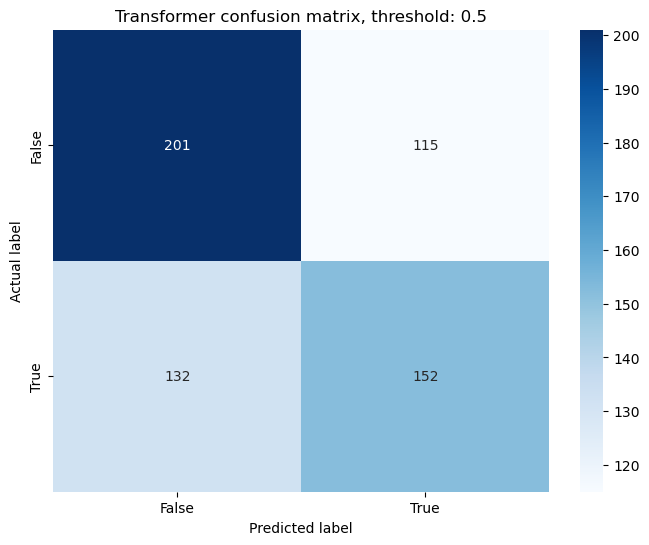

Upper left: true negatives
Upper right: false positives
Lower left: false negatives
Lower right: true positives


In [31]:
plot_cm(predictions, label_test, .5)

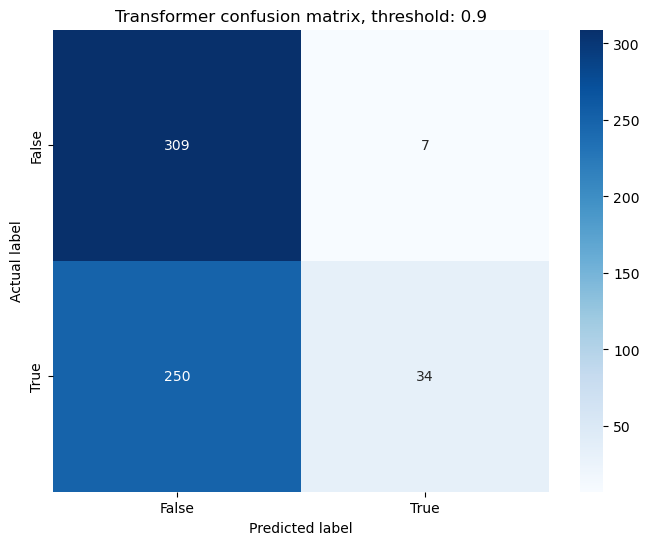

Upper left: true negatives
Upper right: false positives
Lower left: false negatives
Lower right: true positives


In [32]:
plot_cm(predictions, label_test, .9)